## Creating datasets for time-series models (t=1 to t=20)
* based upon the trained CNNs for feature extraction 
* both classification and regression mode and five cross-validation folds
* also plotting here some time-series feature vectors 

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import re
import glob
from keras.models import load_model
from keras.models import Model
from keras import backend as K
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [4]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [atoi(c) for c in re.split('(\d+)', text)]

In [5]:
def get_image(path, stats, rescale_method):
    img = np.load(path)
    img = img.astype('float32')
    return img

In [6]:
def get_gfp(path, stats, rescale_method, fit_method, gfp_thresh):
    gfp = np.load(path)
    if fit_method == 'classify':
        if gfp <= gfp_thresh:
            res = 0.
        else:
            res = 1.
    if fit_method == 'regress':
        if rescale_method == 'log':
            res = np.log(gfp)
        if rescale_method == 'log_center':
            res = np.log(gfp) - np.log(stats[2])
        if rescale_method == 'normalize':
            res = (gfp - stats[0])/(stats[1] - stats[0])
        if rescale_method == 'standardize':
            res = (gfp - stats[2])/stats[3]
        if rescale_method == 'log_normalize':
            res = (np.log(gfp) - np.log(stats[0]))/(np.log(stats[1]) - np.log(stats[0]))
        if rescale_method == 'log_standardize':
            res = (np.log(gfp) - np.log(stats[2]))/np.log(stats[3])
    return res

In [7]:
def rotate90xDegrees(img):
    ret =[]
    rows, cols = img.shape
    for i in range(1,4):
        M = cv2.getRotationMatrix2D((cols/2,rows/2),i*90,1)
        ret.append(cv2.warpAffine(img,M,(cols,rows)))
    return ret

In [8]:
def augment_image(img, aug_no):
    img_new = np.zeros((img.shape)).astype('float32')
    rows, cols, chans = img.shape
    for i in range(chans):
        if aug_no == 0:
            img_new[:, :, i] = img[:, :, i]
        if aug_no == 1:
            img_new[:, :, i] = np.flipud(img[:, :, i])
        if aug_no == 2:
            img_new[:, :, i] = np.fliplr(img[:, :, i])
        if aug_no == 3:
            ud = np.flipud(img[:, :, i])
            img_new[:, :, i] = np.fliplr(ud)
        if aug_no == 4:
            img_new[:, :, i] = rotate90xDegrees(img[:, :, i])[0]
        if aug_no == 5:
            ud = np.flipud(img[:, :, i])
            img_new[:, :, i] = rotate90xDegrees(ud)[0]
        if aug_no == 6:
            lr = np.fliplr(img[:, :, i])
            img_new[:, :, i] = rotate90xDegrees(lr)[0]
        if aug_no == 7:
            ud = np.flipud(img[:, :, i])
            udlr = np.fliplr(ud)
            img_new[:, :, i] = rotate90xDegrees(udlr)[0]
    
    return img_new

### Settings

In [9]:
fold = 'fold5'

wells = ['C04', 'C05', 'E03', 'E04', 'E05', 'G03', 'G04', 'G05']
n_wells = len(wells) 

tpoints = 'T0001'
for i in range(2, 10):
    tpoints = np.append(tpoints, 'T000' + str(i))
for i in range(10, 21):
    tpoints = np.append(tpoints, 'T00' + str(i))
n_time = len(tpoints)

fit_method = 'regress' # 'classify' or 'regress'
# previous explorations showed the following two rescaling methods to be the most appropriate
cell_rescale_method = 'standardize'
gfp_rescale_method = 'log_center'
cell_stats = np.load('/scratch-shared/phil/LNP/LNP_data_09/cell_stats.npy')
gfp_stats = np.load('/scratch-shared/phil/LNP/LNP_data_09/gfp_stats.npy')

latent_dim = 32

CNN = load_model('/scratch-shared/phil/LNP/LNP_data_09/CNN_' + fit_method + '_' + fold + '.h5')
encoder = Model(inputs=CNN.get_layer('input_1').input, outputs=CNN.get_layer('latent_vector').output)

In [10]:
CNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 192, 192, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 192, 192, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 192, 192, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 96, 96, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 96, 96, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 96, 96, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 48, 48, 128)       0         
__________

In [11]:
def predict_ts(pred_cell, encoder):
    for ii, image_path in enumerate(pred_cell):
        for aug_num in range(8):
            img = get_image(image_path, stats=cell_stats, rescale_method=cell_rescale_method)
            img = augment_image(img, aug_no=aug_num)
            img = np.reshape(img, (1, 192, 192, 3))
            pred = np.ndarray.flatten(encoder.predict(img))
            if ii == 0 and aug_num == 0:
                pred_pred = pred
            else:
                pred_pred = np.vstack((pred_pred, pred))
            
    return pred_pred

### Make training time-series data

In [12]:
train_cell_dir = '/scratch-shared/phil/LNP/LNP_data_09/images_train'
train_gfp_dir = '/scratch-shared/phil/LNP/LNP_data_09/gfp_train'

cell_ids = []
cell_gfp = []

all_cell = glob.glob(train_cell_dir + '/' '*')
all_cell = sorted(all_cell, key = natural_keys)
all_gfp = []
cell_well_tpoint = [] # well id and tpoint for each cell in each time point
for cell in all_cell:
    s0 = cell.split('train/')
    s1 = s0[1].split('_')
    f = glob.glob(train_gfp_dir + '/*' + s1[1] + '_' + s1[2] + '_T0072_cell_' + s1[5])
    all_gfp.extend(f)
    cell_well_tpoint.append([s1[1], s1[3]])

t_index = 0
for tpoint in tpoints:
    pred_index = [i for i, index in enumerate(cell_well_tpoint) if index[1] == tpoint]
    pred_cell = [all_cell[i] for i in pred_index]
    pred_gfp = [all_gfp[i] for i in pred_index]
    res = predict_ts(pred_cell, encoder)

    if t_index == 0:
        res_tpoints = np.zeros((len(res), n_time, latent_dim)) 

    res_tpoints[:, t_index, :] = res
    t_index += 1

pred_y = []
for ii, path in enumerate(pred_gfp):
    target = get_gfp(path, stats=gfp_stats, rescale_method=gfp_rescale_method,
                     fit_method=fit_method, gfp_thresh=gfp_stats[4])
    pred_y.append(target)
cell_ids = cell_ids + [ele for ele in pred_cell for i in range(8)] # 8 for 8x augmentations
cell_gfp = cell_gfp + [ele for ele in pred_y for i in range(8)]

np.save('/scratch-shared/phil/LNP/LNP_data_09/train_cell_ids_' + fit_method  + '_' + fold + '.npy', cell_ids)
np.save('/scratch-shared/phil/LNP/LNP_data_09/train_cell_gfp_' + fit_method  + '_' + fold + '.npy', cell_gfp)

np.save('/scratch-shared/phil/LNP/LNP_data_09/train_ts_' + fit_method  + '_' + fold + '.npy', res_tpoints)

### Make testing time-series data

In [13]:
test_cell_dir = '/scratch-shared/phil/LNP/LNP_data_09/images_test'
test_gfp_dir = '/scratch-shared/phil/LNP/LNP_data_09/gfp_test'

cell_ids = []
cell_gfp = []

all_cell = glob.glob(test_cell_dir + '/' '*')
all_cell = sorted(all_cell, key = natural_keys)
all_gfp = []
cell_well_tpoint = [] # well id and tpoint for each cell in each time point
for cell in all_cell:
    s0 = cell.split('test/')
    s1 = s0[1].split('_')
    f = glob.glob(test_gfp_dir + '/' + s1[0] + '_' + s1[1] + '_T0072_cell_' + s1[4])
    all_gfp.extend(f)
    cell_well_tpoint.append([s1[0], s1[2]])

t_index = 0
for tpoint in tpoints:
    pred_index = [i for i, index in enumerate(cell_well_tpoint) if index[1] == tpoint]
    pred_cell = [all_cell[i] for i in pred_index]
    pred_gfp = [all_gfp[i] for i in pred_index]
    res = predict_ts(pred_cell, encoder)

    if t_index == 0:
        res_tpoints = np.zeros((len(res), n_time, latent_dim)) 

    res_tpoints[:, t_index, :] = res
    t_index += 1

pred_y = []
for ii, path in enumerate(pred_gfp):
    target = get_gfp(path, stats=gfp_stats, rescale_method=gfp_rescale_method,
                     fit_method=fit_method, gfp_thresh=gfp_stats[4])
    pred_y.append(target)
cell_ids = cell_ids + [ele for ele in pred_cell for i in range(8)] # 8 for 8x augmentations
cell_gfp = cell_gfp + [ele for ele in pred_y for i in range(8)]

np.save('/scratch-shared/phil/LNP/LNP_data_09/test_cell_ids_' + fit_method + '_' + fold + '.npy', cell_ids)
np.save('/scratch-shared/phil/LNP/LNP_data_09/test_cell_gfp_' + fit_method + '_' + fold + '.npy', cell_gfp)

np.save('/scratch-shared/phil/LNP/LNP_data_09/test_ts_' + fit_method + '_' + fold + '.npy', res_tpoints)

## plot of time series feature vectors for eight augmentations of one cell

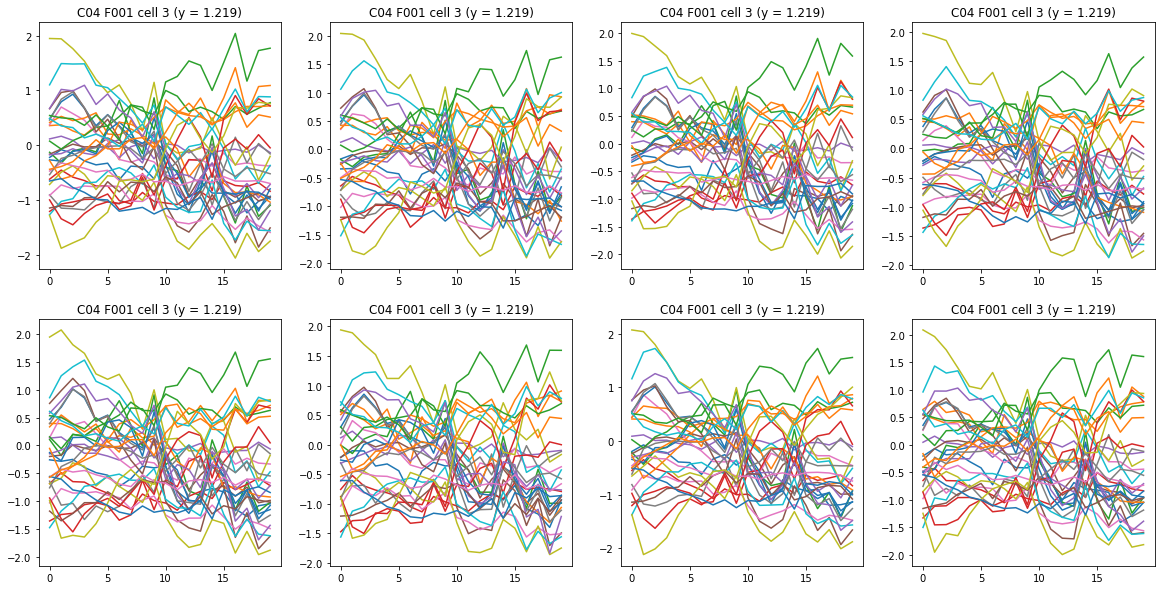

In [14]:
plt.figure(figsize=(20,10), facecolor='w')
cell_index = 0
for i in range(8):
    sub_index = 241 + i
    plt.subplot(sub_index)
    for j in range(latent_dim):
        plt.plot(np.arange(n_time), res_tpoints[i, :, j])
    
    s0 = cell_ids[cell_index].split('test/')
    s1 = s0[1].split('_')
    plt.title(s1[0] +' ' + s1[1] + ' cell ' + s1[4].split('.')[0] +
             ' (y = ' + str(np.round(cell_gfp[cell_index], 3)) + ')')
plt.show()
plt.close() 

## plot of time series feature vectors for a random selection of cells

In [15]:
def plot_rand_samp():
    plt.figure(figsize=(20,10), facecolor='w')
    for i in range(8):
        cell_index = np.random.randint(len(res_tpoints), size=1)[0]
        sub_index = 241 + i
        plt.subplot(sub_index)
        for j in range(latent_dim):
            plt.plot(np.arange(n_time), res_tpoints[cell_index, :, j])

        s0 = cell_ids[cell_index].split('test/')
        s1 = s0[1].split('_')
        plt.title(s1[0] +' ' + s1[1] + ' cell ' + s1[4].split('.')[0] +
                 ' (y = ' + str(np.round(cell_gfp[cell_index], 3)) + ')')
    plt.show()
    plt.close()

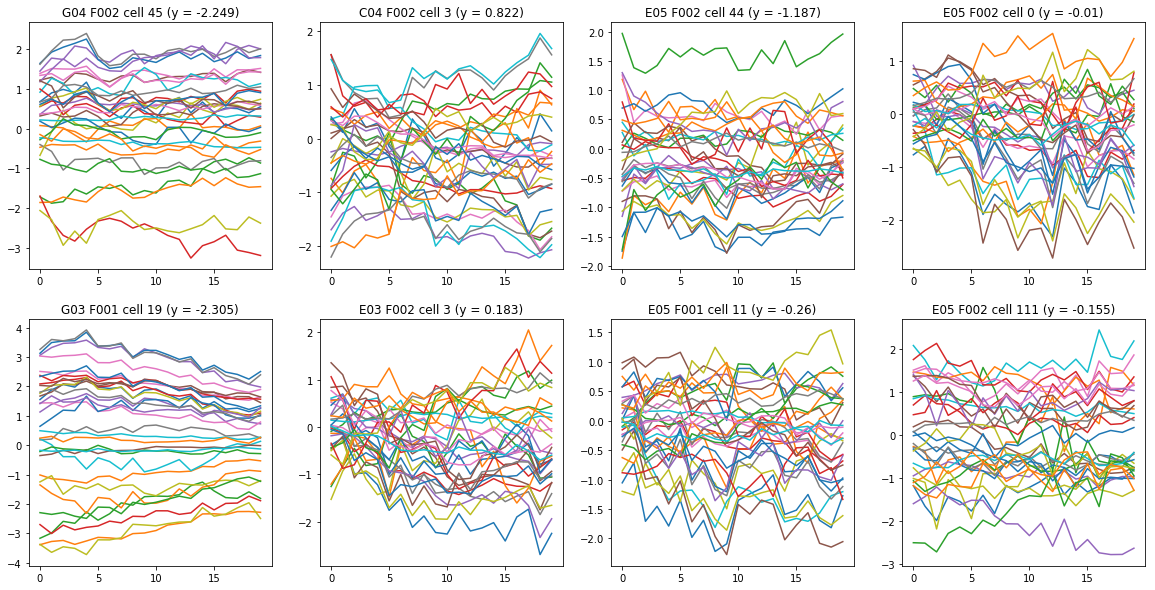

In [16]:
plot_rand_samp()

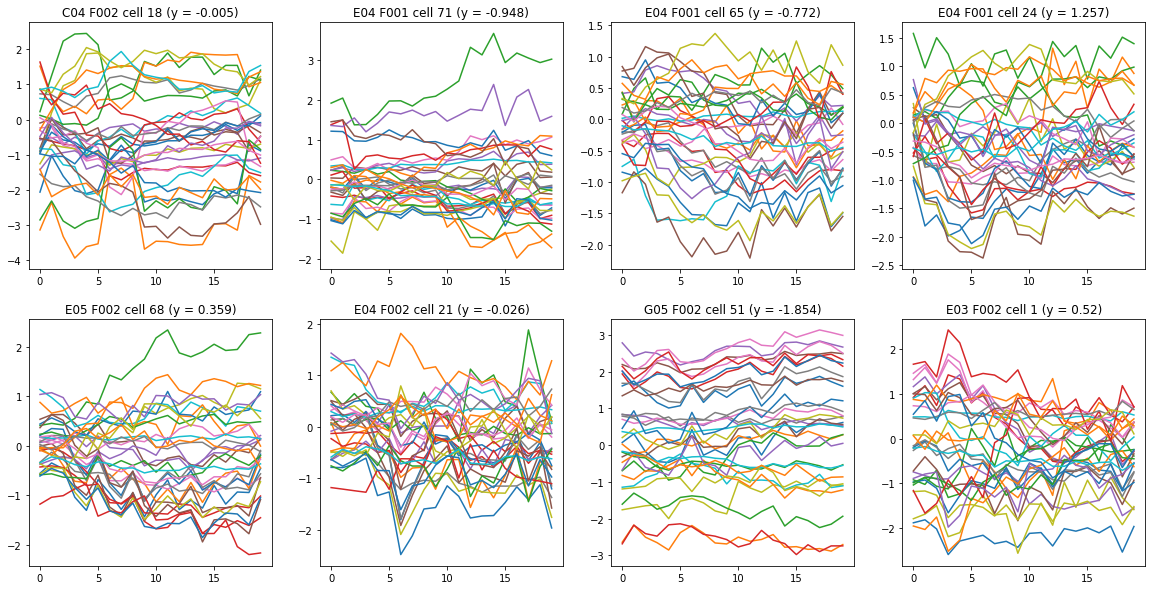

In [17]:
plot_rand_samp()